# Mapping Capstone Project: Semantic Segmentation to Map Floodwater from Radar Imagery

# Installing Requirements

PyTorch Lightning: Our deep learning framework (built on top of PyTorch, removes boilerplate code)
Segmentation Models: pre-trained segmentation models
pandas_path: Path style access for pandas
Rasterio: For interacting with geospatial data

In [ ]:
pip install -U sagemaker

In [ ]:
pip install pytorch-lightning==1.4.5 git+https://github.com/qubvel/segmentation_models.pytorch pandas_path==0.3.0 rasterio==1.2.6 albumentations==0.1.12 wandb --quiet

In [ ]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

# Imports

In [ ]:
import json
import boto3
import sagemaker
from sagemaker.pytorch import PyTorch

# SageMaker Environment Setup

In [ ]:
# Initializes SageMaker session which holds context data
sagemaker_session = sagemaker.Session()

# Our IAM role that allows us to access things
role = sagemaker.get_execution_role()

# Creating an S3 bucket to put our data in
bucket = sagemaker_session.default_bucket()

# Region name
region = sagemaker.session.Session().boto_region_name

# 1. Explore The Data

In [ ]:
import os
if not os.path.exists('../data/'):
    zip_filename = 'floodwater-data.zip'

    !wget https://map-floodwater-driven-data-competition.s3.amazonaws.com/floodwater-data/{zip_filename} -P ../data
    !unzip -qq ../data/{zip_filename} -d ../data

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# This is where our downloaded images and metadata live locally
DATA_PATH = Path("../data/floodwater-data/")

In [ ]:
train_metadata = pd.read_csv(
    DATA_PATH / "flood-training-metadata.csv", parse_dates=["scene_start"]
)

In [ ]:
train_metadata.head()

In [ ]:
# check if there are any duplicate rows
ids = train_metadata['image_id']
train_metadata[ids.isin(ids[ids.duplicated()])].sort_values("image_id")

Looks like there are no duplicates!

Polarization VV (vertical transmit, vertical receive) means that the light that was sent to Earth was in a vertical polarization and it remained vertical after being reflected and going through clouds, etc. This is not necessarily the case and may change depending on the matter which the light is being reflected off of. The light and end up being polarized in either horizontal, circular-left, and circular-right polarization.

It may also be the case that light which is sent as 100% vertical polarization may come back as x% vertically polarized and y% horizontally polarized. This means that the detectors will detect less intensity in the vertical polarization (compared to what it sent), and the rest is either lost intensity through reflection, absorption or changing to another polarization (or unpolarized).

In [ ]:
train_metadata.shape

In [ ]:
train_metadata.chip_id.nunique() # each unique chip has both vv and vh band (542 * 2 = 1084)

In [ ]:
flood_counts = train_metadata.groupby("flood_id")["chip_id"].nunique()
flood_counts.describe()

The training data include chips from 13 flood events. We have anywhere from 15 to 69 chips (30 to 138 images) per unique event, with half of events containing fewer than 32 chips (64 images).

In [ ]:
location_counts = (
    train_metadata.groupby("location")["chip_id"].nunique().sort_values(ascending=False)
)

In [ ]:
plt.figure(figsize=(12, 4))
location_counts.plot(kind="bar", color="lightgray")
plt.xticks(rotation=45)
plt.xlabel("Location")
plt.ylabel("Number of Chips")
plt.title("Number of Chips by Location")

We have a variety of location that definitely have different types of land, so it will be important to train our models to take that into account and test our models on different locations so that we can find out where needs to be the most improvement.

Some locations have way more chips for floods than others, so that means the data is likely much richer in those areas.

In [ ]:
year = train_metadata.scene_start.dt.year
year_counts = train_metadata.groupby(year).nunique()
year_counts

In [ ]:
train_metadata.groupby("flood_id").nunique()

The training data cover flood events that occurred between 2016 and 2020. Images for each event were captured on the same day.

# Loading and Exploring Images

Next, we can begin exploring the image data. We'll add a `feature_path` column to our training metadata, which will contain a `Path` object with the full path to a training image. We'll also add a `label_path` column that points to each image's corresponding water label.

In [ ]:
from pandas_path import path

In [ ]:
train_metadata.chip_id

In [ ]:
train_metadata.chip_id.path.with_suffix(".tif")

In [ ]:
list_of_img_paths = list(str(DATA_PATH / "train_labels") / train_metadata.chip_id.path.with_suffix(".tif").path)
list_of_img_paths[:5]

In [ ]:
train_metadata["feature_path"] = (
    str(DATA_PATH / "train_features") /
    train_metadata.image_id.path.with_suffix(".tif").path
)

In [ ]:
train_metadata["label_path"] = (
    str(DATA_PATH / "train_labels") /
    train_metadata.chip_id.path.with_suffix(".tif").path
)

A GeoTIFF is a raster image file that contains geographic metadata describing the location of the image. This metadata can include bounding coordinates, an affine transform, and a coordinate reference system (CRS) projection. The package [rasterio](https://rasterio.readthedocs.io/en/latest/) makes it easy to interact with our geospatial raster data.

In [ ]:
import rasterio

In [ ]:
train_metadata.feature_path[0]

In [ ]:
# Examine an arbitrary image
image_path = train_metadata.feature_path[0]

In [ ]:
with rasterio.open(image_path) as img:
  metadata = img.meta
  bounds = img.bounds
  data = img.read(1) # read a single polarization band

In [ ]:
metadata

In [ ]:
bounds

In [ ]:
data

We will need to be able to identify pixels with missing data, since we will only be evaluated on predictions made for valid input pixels. The metadata tells us that a value of 0.0 represents missing data for an input image. In rasterio, you can access two different kinds of missing data masks. The first mask is a GDAL-style mask, in which non-zero elements (typically 255) indicate that the corresponding data elements are valid.

In [ ]:
with rasterio.open(image_path) as img:
  gdal_mask = img.dataset_mask()

In [ ]:
gdal_mask

The second mask is a numpy masked array, which has the inverse sense: `True` values indicate that the corresponding data elements are invalid. To load the data as a numpy masked array and access this type of missing data mask, simply pass a `masked` flag to `read`.

In [ ]:
with rasterio.open(image_path) as img:
  numpy_mask = img.read(1, masked=True)

In [ ]:
numpy_mask

Pixel values represent energy that was reflected back to the satellite measured in decibels. To better visualize the bands or channels of Sentinel-1 images, we will create a [false color composite](https://earthobservatory.nasa.gov/features/FalseColor) by treating the two bands and their ratio as red, grean, and blue channels, respectively. We will prepare a few helper functions to visualize the data.

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# Helper functions for visualizing Sentinel-1 images
def scale_img(matrix):
    """
    Returns a scaled (H, W, D) image that is visually inspectable.
    Image is linearly scaled between min_ and max_value, by channel.

    Args:
        matrix (np.array): (H, W, D) image to be scaled

    Returns:
        np.array: Image (H, W, 3) ready for visualization
    """
    # Set min/max values
    min_values = np.array([-23, -28, 0.2])
    max_values = np.array([0, -5, 1])

    # Reshape matrix
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)

    # Scale by min/max
    matrix = (matrix - min_values[None, :]) / (
        max_values[None, :] - min_values[None, :]
    )
    matrix = np.reshape(matrix, [w, h, d])

    # Limit values to 0/1 interval
    return matrix.clip(0, 1)


def create_false_color_composite(path_vv, path_vh):
    """
    Returns a S1 false color composite for visualization.

    Args:
        path_vv (str): path to the VV band
        path_vh (str): path to the VH band

    Returns:
        np.array: image (H, W, 3) ready for visualization
    """
    # Read VV/VH bands
    with rasterio.open(path_vv) as vv:
        vv_img = vv.read(1)
    with rasterio.open(path_vh) as vh:
        vh_img = vh.read(1)

    # Stack arrays along the last dimension
    s1_img = np.stack((vv_img, vh_img), axis=-1)

    # Create false color composite
    img = np.zeros((512, 512, 3), dtype=np.float32)
    img[:, :, :2] = s1_img.copy()
    img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]

    return scale_img(img)


def display_random_chip(random_state):
    """
    Plots a 3-channel representation of VV/VH polarizations as a single chip (image 1).
    Overlays a chip's corresponding water label (image 2).

    Args:
        random_state (int): random seed used to select a chip

    Returns:
        plot.show(): chip and labels plotted with pyplot
    """
    f, ax = plt.subplots(1, 2, figsize=(9, 9))

    # Select a random chip from train_metadata
    random_chip = train_metadata.chip_id.sample(random_state=random_state).values[0]
    chip_df = train_metadata[train_metadata.chip_id == random_chip]

    # Extract paths to image files
    vv_path = chip_df[chip_df.polarization == "vv"].feature_path.values[0]
    vh_path = chip_df[chip_df.polarization == "vh"].feature_path.values[0]
    label_path = chip_df.label_path.values[0]

    # Create false color composite
    s1_img = create_false_color_composite(vv_path, vh_path)

    # Visualize features
    ax[0].imshow(s1_img)
    ax[0].set_title("S1 Chip", fontsize=14)

    # Load water mask
    with rasterio.open(label_path) as lp:
        lp_img = lp.read(1)

    # Mask missing data and 0s for visualization
    label = np.ma.masked_where((lp_img == 0) | (lp_img == 255), lp_img)

    # Visualize water label
    ax[1].imshow(s1_img)
    ax[1].imshow(label, cmap="cool", alpha=1)
    ax[1].set_title("S1 Chip with Water Label", fontsize=14)

    plt.tight_layout(pad=5)
    plt.show()

Let's inspect a few chips and their water labels.

In [353]:
display_random_chip(7)

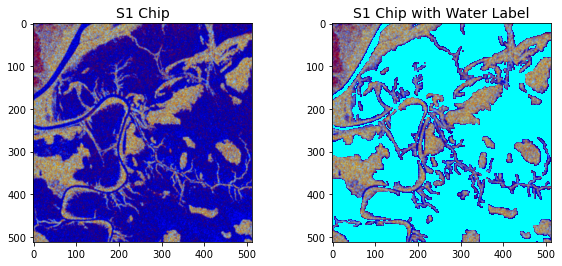

In [354]:
display_random_chip(66)

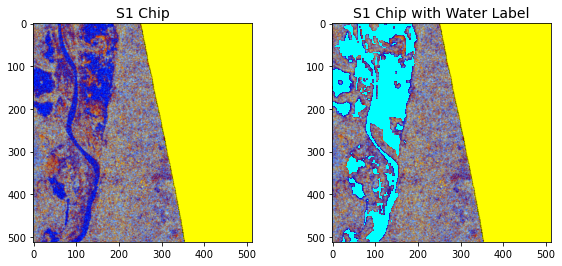

In [355]:
display_random_chip(90)

You'll notice that some images contain high floodwater coverage, while others have little to no coverage. Water spread may be concentrated in one location or spread out, depending on a variety of surface characteristics like topography, terrain, and ground cover. Missing pixels are displayed in yellow.

In [356]:
# Confirming that the images are 512 x 512 pixels.

# examples = [rasterio.open(train_metadata.feature_path[x]) for x in range(len(train_metadata.feature_path))]
# for image in examples:
#     assert image.shape == (512, 512)

# The images are all indeed (512, 512) in shape.
# We are now commenting this code since it takes over 6 minutes to run and
# we've already answered our question.

# Split the Data

Here we will split the data in a simple way, but if we wanted to really test and improve our model, we would create a set of train/test/validation sets so that we can compare all the models on different slice of data.

In [357]:
import pytorch_lightning
from pytorch_lightning import seed_everything
import random

In [358]:
seed_everything(9) # set a seed for reproducibility, seeds torch, numpy, python.random

Global seed set to 9


9

In [359]:
# sample 3 random floods for validation set
flood_ids = train_metadata.flood_id.unique().tolist()
val_flood_ids = random.sample(flood_ids, 3)
val_flood_ids

['pxs', 'qxb', 'jja']

In [360]:
val = train_metadata[train_metadata.flood_id.isin(val_flood_ids)]
train = train_metadata[~train_metadata.flood_id.isin(val_flood_ids)]

Since a single input to our model will contain both VV and VH bands, let's identify our input paths by `chip_id`.

In [361]:
# Helper function for pivoting out paths by chip
def get_paths_by_chip(image_level_df):
    """
    Returns a chip-level dataframe with pivoted columns
    for vv_path and vh_path.

    Args:
        image_level_df (pd.DataFrame): image-level dataframe

    Returns:
        chip_level_df (pd.DataFrame): chip-level dataframe
    """
    paths = []
    for chip, group in image_level_df.groupby("chip_id"):
        vv_path = group[group.polarization == "vv"]["feature_path"].values[0]
        vh_path = group[group.polarization == "vh"]["feature_path"].values[0]
        paths.append([chip, vv_path, vh_path])
    return pd.DataFrame(paths, columns=["chip_id", "vv_path", "vh_path"])

In [362]:
# Separate features from labels
val_x = get_paths_by_chip(val)
val_y = val[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

train_x = get_paths_by_chip(train)
train_y = train[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

In [363]:
train_x

,chip_id,vv_path,vh_path
0,awc00,../data/floodwater-data/train_features/awc00_v...,../data/floodwater-data/train_features/awc00_v...
1,awc01,../data/floodwater-data/train_features/awc01_v...,../data/floodwater-data/train_features/awc01_v...
2,awc02,../data/floodwater-data/train_features/awc02_v...,../data/floodwater-data/train_features/awc02_v...
3,awc03,../data/floodwater-data/train_features/awc03_v...,../data/floodwater-data/train_features/awc03_v...
4,awc04,../data/floodwater-data/train_features/awc04_v...,../data/floodwater-data/train_features/awc04_v...
...,...,...,...
361,wvy27,../data/floodwater-data/train_features/wvy27_v...,../data/floodwater-data/train_features/wvy27_v...
362,wvy28,../data/floodwater-data/train_features/wvy28_v...,../data/floodwater-data/train_features/wvy28_v...
363,wvy29,../data/floodwater-data/train_features/wvy29_v...,../data/floodwater-data/train_features/wvy29_v...
364,wvy30,../data/floodwater-data/train_features/wvy30_v...,../data/floodwater-data/train_features/wvy30_v...


In [364]:
train_y

,chip_id,label_path
0,awc00,../data/floodwater-data/train_labels/awc00.tif
1,awc01,../data/floodwater-data/train_labels/awc01.tif
2,awc02,../data/floodwater-data/train_labels/awc02.tif
3,awc03,../data/floodwater-data/train_labels/awc03.tif
4,awc04,../data/floodwater-data/train_labels/awc04.tif
...,...,...
361,wvy27,../data/floodwater-data/train_labels/wvy27.tif
362,wvy28,../data/floodwater-data/train_labels/wvy28.tif
363,wvy29,../data/floodwater-data/train_labels/wvy29.tif
364,wvy30,../data/floodwater-data/train_labels/wvy30.tif


In [365]:
# Confirm approx. 1/3 of images are in the validation set
len(val_x) / (len(val_x) + len(train_x)) * 100

32.47232472324723

# Send Data to S3

In [366]:
# s3 bucket path (we use this for model training, instead of using local files)
s3_bucket_path = 's3://map-floodwater-driven-data-competition/floodwater-data/'

In [367]:
train_df = train_x.merge(train_y)
val_df = val_x.merge(val_y)
train_df.head()

,chip_id,vv_path,vh_path,label_path
0,awc00,../data/floodwater-data/train_features/awc00_v...,../data/floodwater-data/train_features/awc00_v...,../data/floodwater-data/train_labels/awc00.tif
1,awc01,../data/floodwater-data/train_features/awc01_v...,../data/floodwater-data/train_features/awc01_v...,../data/floodwater-data/train_labels/awc01.tif
2,awc02,../data/floodwater-data/train_features/awc02_v...,../data/floodwater-data/train_features/awc02_v...,../data/floodwater-data/train_labels/awc02.tif
3,awc03,../data/floodwater-data/train_features/awc03_v...,../data/floodwater-data/train_features/awc03_v...,../data/floodwater-data/train_labels/awc03.tif
4,awc04,../data/floodwater-data/train_features/awc04_v...,../data/floodwater-data/train_features/awc04_v...,../data/floodwater-data/train_labels/awc04.tif


In [368]:
for col in train_df.columns[1:]:
    train_df[col] = train_df[col].apply(lambda x: '/opt/ml/input/data/data_s3_uri/' + '/'.join(x.split('/')[3:]))
    val_df[col] = val_df[col].apply(lambda x: '/opt/ml/input/data/data_s3_uri/' + '/'.join(x.split('/')[3:]))
train_df.head()

,chip_id,vv_path,vh_path,label_path
0,awc00,/opt/ml/input/data/data_s3_uri/train_features/...,/opt/ml/input/data/data_s3_uri/train_features/...,/opt/ml/input/data/data_s3_uri/train_labels/aw...
1,awc01,/opt/ml/input/data/data_s3_uri/train_features/...,/opt/ml/input/data/data_s3_uri/train_features/...,/opt/ml/input/data/data_s3_uri/train_labels/aw...
2,awc02,/opt/ml/input/data/data_s3_uri/train_features/...,/opt/ml/input/data/data_s3_uri/train_features/...,/opt/ml/input/data/data_s3_uri/train_labels/aw...
3,awc03,/opt/ml/input/data/data_s3_uri/train_features/...,/opt/ml/input/data/data_s3_uri/train_features/...,/opt/ml/input/data/data_s3_uri/train_labels/aw...
4,awc04,/opt/ml/input/data/data_s3_uri/train_features/...,/opt/ml/input/data/data_s3_uri/train_features/...,/opt/ml/input/data/data_s3_uri/train_labels/aw...


In [369]:
print(train_df['vv_path'][0])
print(train_df['vh_path'][0])
print(train_df['label_path'][0])

/opt/ml/input/data/data_s3_uri/train_features/awc00_vv.tif
/opt/ml/input/data/data_s3_uri/train_features/awc00_vh.tif
/opt/ml/input/data/data_s3_uri/train_labels/awc00.tif


In [370]:
# name of directory we created to save our data
data_dir = '../data/floodwater-data/'

In [371]:
train_df.to_csv(data_dir + 'train_df.csv')
val_df.to_csv(data_dir + 'val_df.csv')

In [372]:
# # takes about 2min30s
# s3_uploader = sagemaker.s3.S3Uploader()

# # upload all data to S3
# data_s3_uri = s3_uploader.upload(local_path=data_dir, desired_s3_uri=f"s3://{bucket}/floodwater_data")

In [373]:
data_s3_uri = 's3://sagemaker-us-east-1-209161541854/floodwater_data'

# Build the Model

The goal of our first pass is to build a relatively simple model that takes radar imagery as input and outputs binary masks that indicate which pixels in a scene contain floodwater. Once we test this basic approach, we can attempt to improve our model by adding additional sophistication and complexity. We will use a lightweight PyTorch wrapper called PyTorch Lightning for this benchmark solution.

Rather than train an entire convolutional neural network (CNN) from scratch, we will tune a U-Net model for semantic segmentation. U-Net was first designed in 2015 to localize abnormalities in biomedical images. By applying a variety of data augmentation techniques, it can achieve high performance using relatively small training datasets. U-Net can be broadly thought of as an encoder network followed by a decoder network, where the encoder can be initialized using a pretrained backbone. For this exercise, we will initialize our encoder using ResNet34. ResNet was prepared by Microsoft Research Asia in 2015 and is pretrained on the ImageNet dataset.

First, we will need to read the training data into memory, convert the data to PyTorch tensors, and serve the data to our model in batches. Luckily, the PyTorch Dataset and DataLoader classes make implementing these complex tasks relatively straightforward. A Dataset object allows us to define custom methods for working with the data, and a DataLoader object parallelizes data loading.





Next, we will create a custom class to define our training loss function and a helper function to calculate our validation metric, Intersection over Union (IOU).

For training, we will use a standard mixture of 50% cross-entropy loss and 50% dice loss, which improves learning when there are unbalanced classes. Since our images tend to contain more non-water than water pixels, this metric should be a good fit. Broadly speaking, cross-entropy loss evaluates differences between predicted and ground truth pixels and averages over all pixels, while dice loss measures overlap between predicted and ground truth pixels and divides a function of this value by the total number of pixels in both images. This custom class will inherit torch.nn.Module, which is the base class for all neural network modules in PyTorch. A lower XEDiceLoss score indicates better performance.

For validation, we will calculate IOU. As a reminder, IOU represents the size of the intersection divided by the size of the union of pixels. A higher IOU indicates better performance.


In [374]:
!pygmentize train/loss_functions.py

import torch
import torch.nn as nn
from torch import tensor


class XEDiceLoss(nn.Module):
    """
    Computes (0.5 * CrossEntropyLoss) + (0.5 * DiceLoss).
    """

    def __init__(self):
        super().__init__()
        self.xe = nn.CrossEntropyLoss(reduction="none")

    def forward(self, pred, true):
        valid_pixel_mask = true.ne(255) # valid pixel mask

#         print(true)
#         print(type(true))
#         print(tensor(0, dtype=torch.double).cuda())
#         print(type(tensor(0, dtype=torch.double).cuda()))
        # Cross-entropy loss
        temp_true = torch.where((true == 255), tensor(0, dtype=torch.long).cuda(), true) # cast 255 to 0 temporarily
        xe_loss = self.xe(pred, temp_true)
        xe_loss = xe_loss.masked_select(valid_pixel_mask).mean()

        # Dice loss
        pred = torch.softmax(pred, dim=1)[:, 1]
        pred = pred.masked_select(valid_pixel_mask)
        true = true.masked_select(valid_pixel_mask)
        dice_loss = 1 - (2.0 * torch.sum

In [375]:
!pygmentize train/metrics.py

import numpy as np


def intersection_and_union(pred, true):
    """
    Calculates intersection and union for a batch of images.

    Args:
        pred (torch.Tensor): a tensor of predictions
        true (torch.Tensor): a tensor of labels

    Returns:
        intersection (int): total intersection of pixels
        union (int): total union of pixels
    """
    valid_pixel_mask = true.ne(255) # valid pixel mask
    true = true.masked_select(valid_pixel_mask).to("cpu")
    pred = pred.masked_select(valid_pixel_mask).to("cpu")

    # Intersection and union totals
    intersection = np.logical_and(true, pred)
    union = np.logical_or(true, pred)
    return intersection.sum(), union.sum()


To prevent overfitting during training, we'll increase the size of our training data by applying a set of data augmentations to our input, including random cropping, random 90 degree rotations, and horizontal and vertical flipping. The image augmentation library albumentations is a helpful resource for this task.

We will now import the SageMaker Hyperparameter Tuner in order to train 2 models. Since I want this notebook to run as fast as possible for the project reviewer, I will use simple architectures and will only train two models. In the real world, I would train a lot more models and choose the best models for ensembling. For this project, I will simply take the two models I train (regardless of their performance) for ensembling.

If we were to train more models, I would do a random search (or perhaps bayesian search) on multiple hyperparameters like learning rate, different architectures and backbones, batch size, etc.

For now, I will only train one model with a Unet architecture and another model with the DeepLab architecture. I won't use the bigger models of those two in order to save time. I'll also only use resnet34 as the backbone since it is the simplest backbone and will train faster.

During training, I will use the BackboneFinetuning callback in PyTorch Lightning in order to finetune the head of the model first (only updating the weights of the head architeture: Unet and DeepLab) and then train the entire model (updating all the weights).

Due to cost and IAM restraints, I cannot use multi-GPU to train the models either so I will need to train the models sequentially with 1 GPU.

In [376]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

In [377]:
# This dictionary only contains the hyperparameter values we want to tune.
# We will add this dictionary as an argument for HyperparameterTuner.

hyperparameter_ranges = {"architecture": CategoricalParameter(["Unet", "DeepLab"])}

In [378]:
# These are the shared hyperparameters between both training runs. 
# We do not include these in the hyperparameter_ranges dictionary that is going in HyperparameterTuner.
hparams = {
    "backbone": "resnet34",
    "weights": "imagenet",
    "lr": 1e-3,
    "min_epochs": 6,
    "max_epochs": 30,
    "patience": 4,
    "batch_size": 32,
    "num_workers": 0,
    "val_sanity_checks": 0,
    "fast_dev_run": False,
    "output_path": "model-outputs",
    "log_path": "tensorboard_logs",
    "gpus": 1
}

Here we will just test that the filename for our pytorch model works correctly.

In [409]:
from datetime import datetime
now = datetime.now()

date_time = now.strftime("%Y-%m-%d-%H-%M-%S")

In [415]:
testhparams = {    
    "architecture": "Unet",
    "backbone": "resnet34",
    "weights": "imagenet",
    "lr": 1e-3,
    "min_epochs": 6,
    "max_epochs": 30,
    "patience": 4,
    "batch_size": 32,
    "num_workers": 0,
    "val_sanity_checks": 0,
    "fast_dev_run": False,
    "output_path": "model-outputs",
    "log_path": "tensorboard_logs",
    "gpus": 1}

In [418]:
# We need to save as string since putting the dictionary in the string won't work, there will be an error.
architecture_name = testhparams['architecture']
backbone_name = testhparams['backbone']

In [419]:
f'model_{architecture_name}_{backbone_name}_{date_time}.pth'

'model_Unet_resnet34_2021-09-24-19-22-41.pth'

Let's create our config for our estimator (model).

In [423]:
estimator_config = {
    "entry_point": 'train.py',
    "source_dir": 'train',
    "role": role,
    "framework_version": '1.6.0',
    "py_version": "py3",
    "instance_count": 1,
    "instance_type": 'ml.p2.xlarge',
    "output_path": f's3://{bucket}',
    "hyperparameters": hparams,
    "base_job_name": 'floodwater'
}

In [424]:
# Creating our PyTorch Estimator with hyperparameters
estimator = PyTorch(**estimator_config)

In [425]:
data_s3_uri

's3://sagemaker-us-east-1-209161541854/floodwater_data'

In [426]:
features_path = data_s3_uri + '/train_features'
labels_path = data_s3_uri + '/train_labels'

We can use Weights and Biases to log our training runs and save our models, but I have commented out all of the wandb code (including in the training files) in order to simplify the notebook. It will add unnecessary complexity for the person reviewing this who does not use wandb.

In [427]:
# import wandb
# wandb.login()

In [428]:
# wandb.sagemaker_auth(path="train")

Next we’ll specify the objective metric that we’d like to tune and its definition, which includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of the training job. In this particular case, our script emits loss value and we will use it as the objective metric, we also set the objective_type to be ‘minimize’, so that hyperparameter tuning seeks to minize the objective metric when searching for the best hyperparameter setting. By default, objective_type is set to ‘maximize’. (from: https://sagemaker-examples.readthedocs.io/en/latest/hyperparameter_tuning/tensorflow_mnist/hpo_tensorflow_mnist.html)

In [429]:
objective_metric_name = 'val_iou'
objective_type = 'Maximize'
metric_definitions = [{"Name": "val_iou", "Regex": "Best score: ([0-9\\.]+)"}]

We are now ready to setup our Hyperparameter Tuning job and start training.

In [430]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,
    strategy="Random",
    objective_type=objective_type,
    base_tuning_job_name='floodwater-tuning'
)

In [431]:
inputs = {'data_s3_uri': data_s3_uri, 'train_features': features_path, 'train_labels': labels_path}

tuner.fit(inputs=inputs, wait=False)

Let’s just run a quick check of the hyperparameter tuning jobs status to make sure it started successfully.

In [432]:
boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

'InProgress'

Below is an example of training on one model. We have commented the code since we are now using a hyperparameter tuning job for training.

In [389]:
# Call fit method on estimator, wich trains our model, passing training
# and testing datasets as environment variables. Data is copied from S3
# before initializing the container
# estimator.fit({'data_s3_uri': data_s3_uri, 'train_features': features_path, 'train_labels': labels_path})

In [ ]:
# last trained model: s3://sagemaker-us-east-1-209161541854/pytorch-training-2021-09-24-00-26-36-373/output/model.tar.gz

In [ ]:
model = PyTorchModel(
    entry_point="inference.py",
    source_dir="serve",
    role=role,
    model_data=estimator.model_data,
    framework_version="1.6.0",
    py_version="py3",
)

In [ ]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

# set local_mode to False if you want to deploy on a remote
# SageMaker instance

local_mode = False

if local_mode:
    instance_type = "local"
else:
    instance_type = "ml.m4.xlarge"

predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
)

In [ ]:
dummy_data = {"inputs": np.random.rand(16, 1, 28, 28).tolist()}

In [ ]:
sagemaker.s3.S3Downloader().download(pytorch_estimator.model_data, "train")
tf = tarfile.open("train/model.tar.gz")
tf.extractall("training_pytorch")

In [ ]:
from train.model import FloodModel

In [ ]:
model = FloodModel()
model.load_state_dict(torch.load("train/model.pt", map_location=torch.device("cpu")))
model.eval();